<a href="https://colab.research.google.com/github/kalyanimeshram151091-max/Fraud-Detection-with-Transaction-Data/blob/main/Project_Fraud_Detection_with_Transaction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Required Libraries**

In [1]:
#Import Required Libraries

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

sns.set(style='whitegrid')

**Create Dummy Dataset**

In [2]:
np.random.seed(42)

n_samples = 10000

transaction_id = [f"TXN_{i}" for i in range(n_samples)]
user_ids = [f"user_{i}" for i in np.random.randint(1, 1001, n_samples)]

start_date = datetime(2023, 1, 1)
timestamps = [start_date + timedelta(minutes=random.randint(0, 60*24*180)) for _ in range(n_samples)]

amounts = np.round(np.random.exponential(scale=500, size=n_samples), 2)

merchant_categories = ['grocery', 'fuel', 'online_shopping', 'restaurant', 'travel', 'electronics']
merchant_category = np.random.choice(merchant_categories, n_samples)

locations = ['Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Chennai', 'Pune']
location = np.random.choice(locations, n_samples)

is_fraud = np.random.choice([0, 1], size=n_samples, p=[0.985, 0.015])

df = pd.DataFrame({
    'transaction_id': transaction_id,
    'user_id': user_ids,
    'timestamp': timestamps,
    'amount': amounts,
    'merchant_category': merchant_category,
    'location': location,
    'is_fraud': is_fraud
})

df.head()


,transaction_id,user_id,timestamp,amount,merchant_category,location,is_fraud
0,TXN_0,user_103,2023-03-13 06:20:00,112.49,fuel,Pune,0
1,TXN_1,user_436,2023-02-08 09:44:00,154.08,travel,Delhi,0
2,TXN_2,user_861,2023-06-01 09:30:00,93.02,grocery,Bangalore,0
3,TXN_3,user_271,2023-06-13 14:18:00,50.26,electronics,Hyderabad,0
4,TXN_4,user_107,2023-02-26 17:47:00,271.62,travel,Chennai,0


**Exploratory Data Analysis (EDA)**

In [3]:


print(df.info())
print(df.describe())
print(df['is_fraud'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_id     10000 non-null  object        
 1   user_id            10000 non-null  object        
 2   timestamp          10000 non-null  datetime64[ns]
 3   amount             10000 non-null  float64       
 4   merchant_category  10000 non-null  object        
 5   location           10000 non-null  object        
 6   is_fraud           10000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 547.0+ KB
None
                        timestamp        amount      is_fraud
count                       10000  10000.000000  10000.000000
mean   2023-04-01 02:06:24.048000    499.346203      0.016400
min           2023-01-01 00:46:00      0.060000      0.000000
25%           2023-02-14 23:11:00    147.200000      0.000000


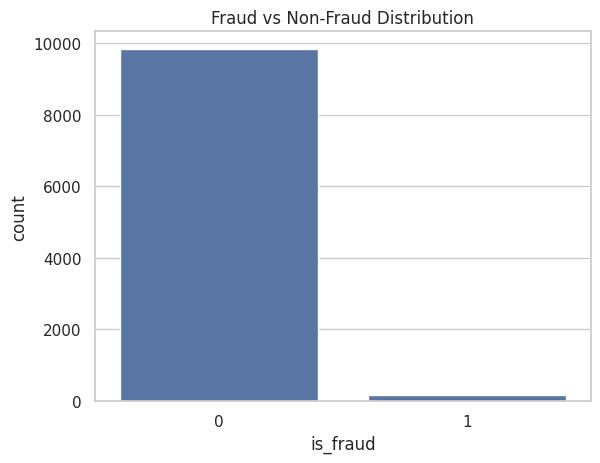

In [4]:
# Plot fraud distribution
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()


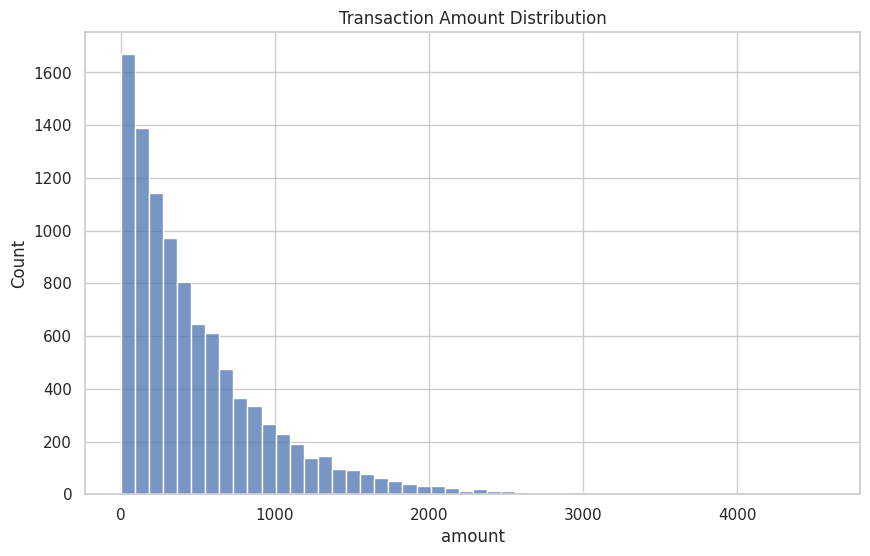

In [5]:
# Amount distribution
plt.figure(figsize=(10,6))
sns.histplot(df['amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.show()

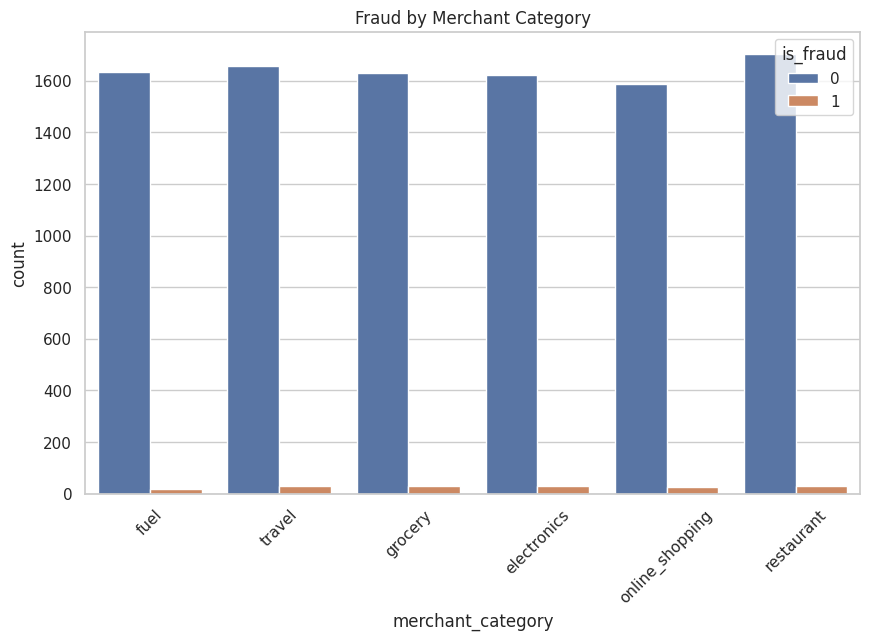

In [6]:
# Fraud by merchant category
plt.figure(figsize=(10,6))
sns.countplot(x='merchant_category', hue='is_fraud', data=df)
plt.xticks(rotation=45)
plt.title('Fraud by Merchant Category')
plt.show()

**Feature Engineering**

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

df = df.sort_values(by=['user_id', 'timestamp'])

df['transaction_count_last_24h'] = 0
df['avg_amount_last_24h'] = 0.0
df['is_unusual_amount'] = 0
df['transaction_count_last_24h_merchant'] = 0

for i in range(len(df)):
    user = df.iloc[i]['user_id']
    merchant = df.iloc[i]['merchant_category']
    current_time = df.iloc[i]['timestamp']

    past_24h = df[
        (df['user_id'] == user) &
        (df['timestamp'] < current_time) &
        (df['timestamp'] >= current_time - pd.Timedelta(hours=24))
    ]
    df.at[df.index[i], 'transaction_count_last_24h'] = len(past_24h)
    df.at[df.index[i], 'avg_amount_last_24h'] = past_24h['amount'].mean() if len(past_24h) > 0 else 0

    user_avg = df[df['user_id'] == user]['amount'].mean()
    if df.iloc[i]['amount'] > 2 * user_avg:
        df.at[df.index[i], 'is_unusual_amount'] = 1

    merchant_past_24h = df[
        (df['merchant_category'] == merchant) &
        (df['timestamp'] < current_time) &
        (df['timestamp'] >= current_time - pd.Timedelta(hours=24))
    ]
    df.at[df.index[i], 'transaction_count_last_24h_merchant'] = len(merchant_past_24h)

df['avg_amount_last_24h'] = df['avg_amount_last_24h'].fillna(0)
df.head()


,transaction_id,user_id,timestamp,amount,merchant_category,location,is_fraud,hour_of_day,day_of_week,transaction_count_last_24h,avg_amount_last_24h,is_unusual_amount,transaction_count_last_24h_merchant
1357,TXN_1357,user_1,2023-01-19 00:46:00,524.84,electronics,Bangalore,0,0,3,0,0.00,0,6
8815,TXN_8815,user_1,2023-02-17 08:47:00,596.09,online_shopping,Pune,0,8,4,0,0.00,0,7
897,TXN_897,user_1,2023-03-06 12:54:00,664.06,electronics,Pune,0,12,0,0,0.00,0,8
4934,TXN_4934,user_1,2023-03-06 21:10:00,601.23,online_shopping,Pune,0,21,0,1,664.06,0,8
1585,TXN_1585,user_1,2023-03-11 20:15:00,128.87,electronics,Chennai,0,20,5,0,0.00,0,8


**Model Building**

In [8]:
df_encoded = pd.get_dummies(df, columns=['merchant_category', 'location'], drop_first=True)

features = [
    'amount', 'hour_of_day', 'day_of_week',
    'transaction_count_last_24h',
    'avg_amount_last_24h',
    'is_unusual_amount',
    'transaction_count_last_24h_merchant'
] + [col for col in df_encoded.columns if col.startswith('merchant_category_') or col.startswith('location_')]

X = df_encoded[features]
y = df_encoded['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8000, 17) Test shape: (2000, 17)


**Train & Evaluate Models**

In [9]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1967
           1       0.00      0.00      0.00        33

    accuracy                           0.98      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.97      0.98      0.98      2000

ROC AUC: 0.6338216943199149


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1967
           1       0.00      0.00      0.00        33

    accuracy                           0.98      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.97      0.98      0.98      2000

ROC AUC: 0.4376376885273683


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

XGBoost
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1967
           1       0.00      0.00      0.00        33

    accuracy                           0.98      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.97      0.98      0.98      2000

ROC AUC: 0.3770085193572738


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:31:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

**Visualize Confusion Matrix**

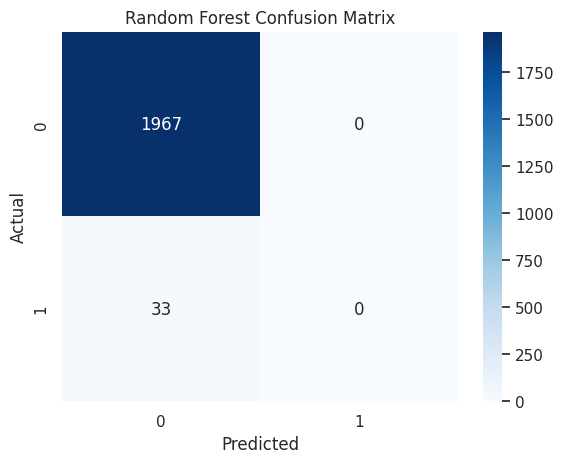

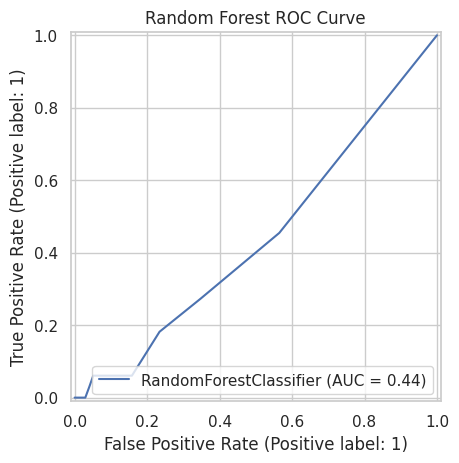

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('Random Forest ROC Curve')
plt.show()

**Insights & Recommendations**



*   Fraud cases are rare (~1–2%), so focus on recall and precision rather than accuracy.

*  Time-based and user-level features dramatically improve fraud detection performance
*   Random Forest or XGBoost usually outperforms Logistic Regression in fraud detection.


*   The model can be deployed to flag suspicious transactions in real-time.

